## Antiguo proyecto de Redes Neuronales Recurrentes usando audios .wav, obteniendo su MFCC, aplicandolos a una RNN y validandolo con k fold cross validation

#### Librerias

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import os
import soundfile as sf
import json
import random
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from keras import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
random.seed(0)

#### Conseguir los paths

In [3]:
#Obtiene el path con el nombre de todos los archivos de un directorio.
def get_files_from_path(directory):
    path_files = []
    dir_list = os.listdir(directory)
    for path in dir_list:
        path_files.append(directory+"\\"+path)
    return path_files


#Extrae los paths que cumplan con un codigo
def extract_paths_for_emotions_keys(emotions_code, files_path, get_code):
    paths = []
    emotions_set = set(emotions_code)
    for code_file in files_path:
        if (get_code(code_file) in emotions_set):
            paths.append(code_file)
    return paths


#Obtiene el codigo en el nombre del archivo para el dataset CREMA-D
def get_code_crema_d(path):
    return path[119:122]


#Obtiene el codigo en el nombre del archivo para el dataset SAVEE
def get_code_savee(path):
    return path[108]


#Esta función abre el archivo .wav y obtiene el mfcc escalado en un vector de 40 elementos.
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features


#Esta función permite guardar los MFCC en 'features', el código en 'code' y su dirección en 'path' en un archivo json. 
def save_elements_in_json(examples_saved, name):
    json_files = []
    json_file = {}
    index = 0
    for file in examples_saved:
        json_file = {"id": index, "features":[str(elem) for elem in file[0]] ,"code":file[1], "path":file[2]}
        json_files.append(json_file)
        index += 1
    json_object = json.dumps(json_files)
    with open(f"{name}.json", "w") as outfile:
        outfile.write(json_object)
   

#La función permite cargar datos del MFCC y código desde un archivo json.
def load_elements_from_json(name):
    f = open(f'{name}.json')
    data = json.load(f)
    examples = []
    for element in data:
        examples.append(([float(feature) for feature in (element["features"])], element["code"]))
    return examples


#La función nos permite devolver una lista de MFCC obtenidos de una lista de paths. 
#El MFCC tiene un límite que no le permite cargar archivos menor o igual a 44 kb.
#Con el diccionario obtenemos el total de audios recuperados por emoción.
def get_features(paths,get_code, files_filters = dict()):
    examples = []
    for path in paths:
        code = get_code(path)
        file_stats = os.stat(path)
        if (file_stats.st_size > 44):
            feature = features_extractor(path)
            files_filters[code]+= 1
            examples.append((feature,code))
    print(f"Se obtuvo el MFCC de unos {len(paths)} sobre {sum(files_filters[files] for files in files_filters)} audios.")
    return examples


#Selecciona n ejemplos que necesitemos y los mezcla.
def select_elements(examples, code, quantity, new_code):
    random.shuffle(examples)
    elements = []
    counter = 1
    for example in examples:
        if (counter > quantity):
            break
        if code == example[1]:
            elements.append((example[0],new_code))
            counter = counter + 1
    return elements

Los siguientes bloques obtienen los paths y filtra las emociones que necesitemos en cada dataset (CREMA-D y SAVEE).

In [5]:
files_path = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\AudioWav")
emotions_code = ["NEU", "FEA","ANG"]
datas_files = extract_paths_for_emotions_keys(emotions_code, files_path, get_code_crema_d)

files_path_s = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\ALL")
emotions_code_s = ["a", "f","n"]
datas_files_s = extract_paths_for_emotions_keys(emotions_code_s, files_path_s, get_code_savee) 

examples = []

files_filters = dict()
files_filters["NEU"] = 0
files_filters["FEA"] = 0
files_filters["ANG"] = 0
files_filters["a"] = 0
files_filters["f"] = 0
files_filters["n"] = 0

#### Guardar los pesos y la configuracion

In [28]:
# serialize model to JSON
model_json = model.to_json()
with open("model_5.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_5.h5")
print("Saved model to disk")

Saved model to disk


In [34]:

examples = get_features(datas_files, get_code_crema_d, files_filters)
examples_s = get_features(datas_files_s, get_code_savee, files_filters)

es = examples + examples_s
entries = []


for example in es:
    entries.append((example[0], example[1]))
datas = select_elements(entries, 'NEU', 896,"without_stress")
datas += select_elements(entries, 'ANG', 550, "stress")
datas += select_elements(entries, 'FEA', 550, "stress")
datas += select_elements(entries, 'a', 60, "stress")
datas += select_elements(entries, 'f', 60, "stress")
datas += select_elements(entries, 'n', 120, "without_stress")
random.shuffle(datas)

X = []
y = []
for data in datas:
    X.append(data[0])
    y.append(data[1])
labelencoder=preprocessing.LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2,random_state=0)
print(len(X_train),len(X_test),len(y_train),len(y_test))
y = np.array(y)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
num_labels = y.shape[1]
dim_entrada = (X_train.shape[1],1)
    

model = Sequential()
model.add(LSTM(units=50,input_shape= dim_entrada))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

num_epochs = 400
num_batch_size = 32
start = datetime.datetime.now()
   
results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test))
duration = datetime.datetime.now() - start
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")
y_values = model.predict(X_test)
y_prediction=[([1,0] if i[0]>i[1] else [0,1]) for i in y_values]
y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

Se obtuvo el MFCC de unos 3629 sobre 26836 audios.
Se obtuvo el MFCC de unos 240 sobre 27076 audios.
1788 448 1788 448
Epoch 1/400
28/28 [==============================] - 15s 161ms/step - loss: 0.6863 - accuracy: 0.5341 - val_loss: 0.6659 - val_accuracy: 0.5781
Epoch 2/400
28/28 [==============================] - 3s 108ms/step - loss: 0.6692 - accuracy: 0.5666 - val_loss: 0.6482 - val_accuracy: 0.6138
Epoch 3/400
28/28 [==============================] - 3s 105ms/step - loss: 0.6379 - accuracy: 0.6135 - val_loss: 0.6049 - val_accuracy: 0.6607
Epoch 4/400
28/28 [==============================] - 3s 107ms/step - loss: 0.5957 - accuracy: 0.6594 - val_loss: 0.5797 - val_accuracy: 0.6696
Epoch 5/400
28/28 [==============================] - 3s 106ms/step - loss: 0.5708 - accuracy: 0.6902 - val_loss: 0.5410 - val_accuracy: 0.6942
Epoch 6/400
28/28 [==============================] - 3s 108ms/step - loss: 0.5657 - accuracy: 0.6885 - val_loss: 0.5350 - val_accuracy: 0.7210
Epoch 7/400
28/28 [===

28/28 [==============================] - 3s 106ms/step - loss: 0.3925 - accuracy: 0.8065 - val_loss: 0.4302 - val_accuracy: 0.7857
Epoch 58/400
28/28 [==============================] - 3s 108ms/step - loss: 0.3884 - accuracy: 0.8110 - val_loss: 0.4162 - val_accuracy: 0.7835
Epoch 59/400
28/28 [==============================] - 3s 105ms/step - loss: 0.3782 - accuracy: 0.8249 - val_loss: 0.4302 - val_accuracy: 0.7701
Epoch 60/400
28/28 [==============================] - 3s 105ms/step - loss: 0.3710 - accuracy: 0.8210 - val_loss: 0.4207 - val_accuracy: 0.7879
Epoch 61/400
28/28 [==============================] - 3s 107ms/step - loss: 0.3784 - accuracy: 0.8166 - val_loss: 0.4633 - val_accuracy: 0.7522
Epoch 62/400
28/28 [==============================] - 3s 106ms/step - loss: 0.3926 - accuracy: 0.8037 - val_loss: 0.4584 - val_accuracy: 0.7522
Epoch 63/400
28/28 [==============================] - 3s 107ms/step - loss: 0.3894 - accuracy: 0.8138 - val_loss: 0.4346 - val_accuracy: 0.7946
Epoch

Epoch 114/400
28/28 [==============================] - 3s 116ms/step - loss: 0.2981 - accuracy: 0.8652 - val_loss: 0.4440 - val_accuracy: 0.8080
Epoch 115/400
28/28 [==============================] - 3s 118ms/step - loss: 0.2940 - accuracy: 0.8758 - val_loss: 0.4552 - val_accuracy: 0.7723
Epoch 116/400
28/28 [==============================] - 3s 117ms/step - loss: 0.3093 - accuracy: 0.8619 - val_loss: 0.4194 - val_accuracy: 0.8125
Epoch 117/400
28/28 [==============================] - 3s 120ms/step - loss: 0.3350 - accuracy: 0.8423 - val_loss: 0.4723 - val_accuracy: 0.7612
Epoch 118/400
28/28 [==============================] - 3s 116ms/step - loss: 0.3159 - accuracy: 0.8607 - val_loss: 0.4491 - val_accuracy: 0.8013
Epoch 119/400
28/28 [==============================] - 3s 117ms/step - loss: 0.2967 - accuracy: 0.8674 - val_loss: 0.4292 - val_accuracy: 0.7879
Epoch 120/400
28/28 [==============================] - 3s 120ms/step - loss: 0.2872 - accuracy: 0.8725 - val_loss: 0.4352 - val_ac

28/28 [==============================] - 3s 115ms/step - loss: 0.2222 - accuracy: 0.9032 - val_loss: 0.7092 - val_accuracy: 0.7879
Epoch 171/400
28/28 [==============================] - 3s 118ms/step - loss: 0.2732 - accuracy: 0.8781 - val_loss: 0.5266 - val_accuracy: 0.7812
Epoch 172/400
28/28 [==============================] - 3s 119ms/step - loss: 0.2404 - accuracy: 0.8993 - val_loss: 0.5708 - val_accuracy: 0.8036
Epoch 173/400
28/28 [==============================] - 3s 117ms/step - loss: 0.2338 - accuracy: 0.8954 - val_loss: 0.6122 - val_accuracy: 0.7634
Epoch 174/400
28/28 [==============================] - 3s 117ms/step - loss: 0.3179 - accuracy: 0.8602 - val_loss: 0.4929 - val_accuracy: 0.7790
Epoch 175/400
28/28 [==============================] - 3s 115ms/step - loss: 0.2908 - accuracy: 0.8708 - val_loss: 0.4685 - val_accuracy: 0.7768
Epoch 176/400
28/28 [==============================] - 3s 116ms/step - loss: 0.2459 - accuracy: 0.8921 - val_loss: 0.6455 - val_accuracy: 0.7946

28/28 [==============================] - 1s 46ms/step - loss: 0.2027 - accuracy: 0.9167 - val_loss: 0.7073 - val_accuracy: 0.7701
Epoch 227/400
28/28 [==============================] - 1s 45ms/step - loss: 0.2017 - accuracy: 0.9139 - val_loss: 0.6315 - val_accuracy: 0.7902
Epoch 228/400
28/28 [==============================] - 1s 46ms/step - loss: 0.1781 - accuracy: 0.9223 - val_loss: 0.6916 - val_accuracy: 0.8080
Epoch 229/400
28/28 [==============================] - 1s 46ms/step - loss: 0.1785 - accuracy: 0.9211 - val_loss: 0.7177 - val_accuracy: 0.7857
Epoch 230/400
28/28 [==============================] - 1s 44ms/step - loss: 0.1765 - accuracy: 0.9217 - val_loss: 0.6723 - val_accuracy: 0.7924
Epoch 231/400
28/28 [==============================] - 1s 45ms/step - loss: 0.1721 - accuracy: 0.9284 - val_loss: 0.7348 - val_accuracy: 0.7924
Epoch 232/400
28/28 [==============================] - 1s 45ms/step - loss: 0.1745 - accuracy: 0.9228 - val_loss: 0.7285 - val_accuracy: 0.7969
Epoch 

Epoch 283/400
28/28 [==============================] - 1s 44ms/step - loss: 0.1571 - accuracy: 0.9273 - val_loss: 0.7746 - val_accuracy: 0.7879
Epoch 284/400
28/28 [==============================] - 1s 46ms/step - loss: 0.1371 - accuracy: 0.9295 - val_loss: 0.8402 - val_accuracy: 0.7924
Epoch 285/400
28/28 [==============================] - 1s 44ms/step - loss: 0.1302 - accuracy: 0.9402 - val_loss: 0.8804 - val_accuracy: 0.7812
Epoch 286/400
28/28 [==============================] - 1s 43ms/step - loss: 0.1218 - accuracy: 0.9424 - val_loss: 0.8548 - val_accuracy: 0.7679
Epoch 287/400
28/28 [==============================] - 1s 43ms/step - loss: 0.1284 - accuracy: 0.9390 - val_loss: 0.9121 - val_accuracy: 0.7612
Epoch 288/400
28/28 [==============================] - 1s 45ms/step - loss: 0.1465 - accuracy: 0.9306 - val_loss: 0.7499 - val_accuracy: 0.7902
Epoch 289/400
28/28 [==============================] - 1s 42ms/step - loss: 0.1371 - accuracy: 0.9390 - val_loss: 0.8710 - val_accuracy:

Epoch 340/400
28/28 [==============================] - 1s 48ms/step - loss: 0.0792 - accuracy: 0.9664 - val_loss: 1.0128 - val_accuracy: 0.7723
Epoch 341/400
28/28 [==============================] - 1s 45ms/step - loss: 0.0782 - accuracy: 0.9676 - val_loss: 1.0333 - val_accuracy: 0.7857
Epoch 342/400
28/28 [==============================] - 1s 45ms/step - loss: 0.0733 - accuracy: 0.9687 - val_loss: 1.0303 - val_accuracy: 0.7790
Epoch 343/400
28/28 [==============================] - 1s 47ms/step - loss: 0.0701 - accuracy: 0.9732 - val_loss: 1.0506 - val_accuracy: 0.7790
Epoch 344/400
28/28 [==============================] - 1s 46ms/step - loss: 0.0753 - accuracy: 0.9692 - val_loss: 1.2208 - val_accuracy: 0.7812
Epoch 345/400
28/28 [==============================] - 1s 45ms/step - loss: 0.1213 - accuracy: 0.9564 - val_loss: 1.1222 - val_accuracy: 0.7545
Epoch 346/400
28/28 [==============================] - 1s 46ms/step - loss: 0.1220 - accuracy: 0.9519 - val_loss: 1.1544 - val_accuracy:

Epoch 397/400
28/28 [==============================] - 1s 49ms/step - loss: 0.1213 - accuracy: 0.9519 - val_loss: 1.0605 - val_accuracy: 0.7679
Epoch 398/400
28/28 [==============================] - 1s 46ms/step - loss: 0.0671 - accuracy: 0.9720 - val_loss: 1.0475 - val_accuracy: 0.7679
Epoch 399/400
28/28 [==============================] - 1s 47ms/step - loss: 0.0458 - accuracy: 0.9827 - val_loss: 1.1037 - val_accuracy: 0.7835
Epoch 400/400
28/28 [==============================] - 1s 52ms/step - loss: 0.0375 - accuracy: 0.9866 - val_loss: 1.1700 - val_accuracy: 0.7835
val_loss: 1.170000672340393 val_accuracy: 0.7834821343421936
14/14 [==============================] - 1s 9ms/step
El algoritmo acerto 351 veces sobre los 448 casos.


Este bloque ejecuta todo el código que vimos.

In [35]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")

y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
    
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

val_loss: 1.170000672340393 val_accuracy: 0.7834821343421936
El algoritmo acerto 351 veces sobre los 448 casos.


In [36]:
training_loss = results.history['loss']
test_loss = results.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)

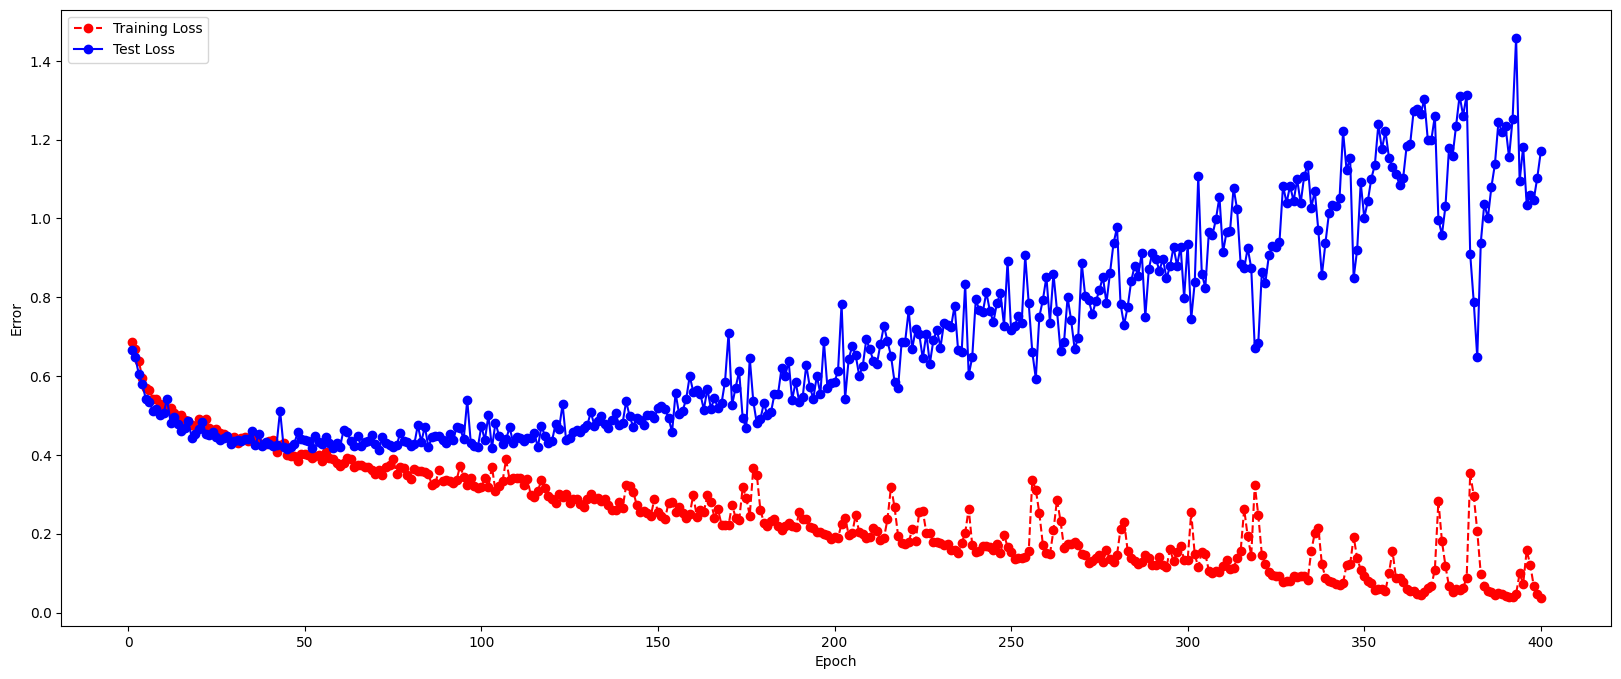

In [37]:
plt.plot(epochs_range, training_loss, 'r',marker="o",linestyle="--")
plt.plot(epochs_range, test_loss, 'b',marker="o",linestyle="-")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

In [81]:
'''
val_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128
val_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128
val_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808
'''

'\nval_loss: 0.42675861716270447 val_accuracy: 0.7767857313156128\nval_loss: 0.44326552748680115 val_accuracy: 0.7611607313156128\nval_loss: 0.4475260078907013 val_accuracy: 0.7566964030265808\n'

#### Crossvalidation

In [39]:
X = np.array(X)
y = np.array(y)
print(f"X:{X.shape} y:{y.shape}")

X:(2236, 40) y:(2236, 2)


In [40]:
k_fold = KFold(5)
fold = 0
y_tests = []
predictions = []
results = []
for train, test in k_fold.split(X):
    fold = fold + 1
    print(f"Fold #{fold}")
    
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    print(f"Train - X:{X_train.shape} y:{y_train.shape}")
    print(f"Test - X:{X_test.shape} y:{y_test.shape}")
    
    num_labels = y.shape[1]
    dim_entrada = (X_train.shape[1],1)

    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')
    
    num_epochs = 400
    num_batch_size = 64

    model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test))
    
    pred = model.predict(X_test)
    y_tests.append(y_test)
    pred=[([1,0] if i[0]>i[1] else [0,1]) for i in pred]
    predictions.append(pred)
    score = metrics.accuracy_score(pred, y_test)
    math = confusion_matrix([(1 if x[0]==1 else 0) for x in pred],[(1 if x[0]==1 else 0) for x in y_test], labels=[1,0])
    results.append([score])
    print(f"Fold score (Accuracy score): {score}")
    print("Matriz de confusion")
    print("-------------------")
    print("---------| Verdadero | Falso |")
    print(f"Verdadero|  {math[0][0]}        {math[0][1]}")
    print(f"Falso    |  {math[1][0]}        {math[1][1]}")

y_tests = np.concatenate(y_tests)
predictions = np.concatenate(predictions)
score = metrics.accuracy_score(pred, y_test)
print("-----------------------")
print(f"Cross-validated score (Accuracy score): {score}")
print("-----------------------")
print("Resumen")
for result in results:
    print(f"Fold score (Accuracy score): {result[0]}")
    
#https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_05_2_kfold.ipynb
#https://www.youtube.com/watch?v=maiQf8ray_s

Fold #1
Train - X:(1788, 40) y:(1788, 2)
Test - X:(448, 40) y:(448, 2)
Epoch 1/400
28/28 [==============================] - 6s 140ms/step - loss: 0.6933 - accuracy: 0.5095 - val_loss: 0.6841 - val_accuracy: 0.5179
Epoch 2/400
28/28 [==============================] - 1s 44ms/step - loss: 0.6661 - accuracy: 0.5688 - val_loss: 0.6554 - val_accuracy: 0.6116
Epoch 3/400
28/28 [==============================] - 1s 42ms/step - loss: 0.6162 - accuracy: 0.6616 - val_loss: 0.5950 - val_accuracy: 0.6674
Epoch 4/400
28/28 [==============================] - 1s 39ms/step - loss: 0.5809 - accuracy: 0.6980 - val_loss: 0.5796 - val_accuracy: 0.6808
Epoch 5/400
28/28 [==============================] - 1s 40ms/step - loss: 0.5706 - accuracy: 0.6952 - val_loss: 0.5726 - val_accuracy: 0.6763
Epoch 6/400
28/28 [==============================] - 1s 39ms/step - loss: 0.5606 - accuracy: 0.6969 - val_loss: 0.5806 - val_accuracy: 0.6629
Epoch 7/400
28/28 [==============================] - 1s 39ms/step - loss: 0.

Epoch 58/400
28/28 [==============================] - 1s 42ms/step - loss: 0.3905 - accuracy: 0.8015 - val_loss: 0.4754 - val_accuracy: 0.7746
Epoch 59/400
28/28 [==============================] - 1s 41ms/step - loss: 0.4139 - accuracy: 0.7925 - val_loss: 0.4518 - val_accuracy: 0.7679
Epoch 60/400
28/28 [==============================] - 1s 42ms/step - loss: 0.4127 - accuracy: 0.7808 - val_loss: 0.4319 - val_accuracy: 0.7835
Epoch 61/400
28/28 [==============================] - 1s 41ms/step - loss: 0.4079 - accuracy: 0.7959 - val_loss: 0.5499 - val_accuracy: 0.7188
Epoch 62/400
28/28 [==============================] - 1s 42ms/step - loss: 0.4310 - accuracy: 0.7713 - val_loss: 0.4591 - val_accuracy: 0.7612
Epoch 63/400
28/28 [==============================] - 1s 41ms/step - loss: 0.3967 - accuracy: 0.7925 - val_loss: 0.4808 - val_accuracy: 0.7589
Epoch 64/400
28/28 [==============================] - 1s 42ms/step - loss: 0.4119 - accuracy: 0.7836 - val_loss: 0.4538 - val_accuracy: 0.7634

28/28 [==============================] - 1s 41ms/step - loss: 0.3483 - accuracy: 0.8289 - val_loss: 0.4343 - val_accuracy: 0.7879
Epoch 116/400
28/28 [==============================] - 1s 41ms/step - loss: 0.3399 - accuracy: 0.8322 - val_loss: 0.4572 - val_accuracy: 0.7768
Epoch 117/400
28/28 [==============================] - 1s 43ms/step - loss: 0.3391 - accuracy: 0.8361 - val_loss: 0.4557 - val_accuracy: 0.7835
Epoch 118/400
28/28 [==============================] - 1s 43ms/step - loss: 0.3364 - accuracy: 0.8378 - val_loss: 0.4501 - val_accuracy: 0.7723
Epoch 119/400
28/28 [==============================] - 1s 43ms/step - loss: 0.3796 - accuracy: 0.8110 - val_loss: 0.5486 - val_accuracy: 0.7054
Epoch 120/400
28/28 [==============================] - 1s 42ms/step - loss: 0.4310 - accuracy: 0.7836 - val_loss: 0.4795 - val_accuracy: 0.7388
Epoch 121/400
28/28 [==============================] - 1s 42ms/step - loss: 0.3713 - accuracy: 0.8126 - val_loss: 0.4342 - val_accuracy: 0.7857
Epoch 

Epoch 172/400
28/28 [==============================] - 1s 42ms/step - loss: 0.3035 - accuracy: 0.8540 - val_loss: 0.5304 - val_accuracy: 0.7679
Epoch 173/400
28/28 [==============================] - 1s 43ms/step - loss: 0.2983 - accuracy: 0.8624 - val_loss: 0.5544 - val_accuracy: 0.7924
Epoch 174/400
28/28 [==============================] - 1s 43ms/step - loss: 0.2802 - accuracy: 0.8630 - val_loss: 0.5229 - val_accuracy: 0.7924
Epoch 175/400
28/28 [==============================] - 1s 42ms/step - loss: 0.2771 - accuracy: 0.8658 - val_loss: 0.4985 - val_accuracy: 0.7835
Epoch 176/400
28/28 [==============================] - 1s 43ms/step - loss: 0.2890 - accuracy: 0.8596 - val_loss: 0.5283 - val_accuracy: 0.7746
Epoch 177/400
28/28 [==============================] - 1s 48ms/step - loss: 0.2773 - accuracy: 0.8591 - val_loss: 0.5033 - val_accuracy: 0.7812
Epoch 178/400
28/28 [==============================] - 1s 44ms/step - loss: 0.2620 - accuracy: 0.8758 - val_loss: 0.5351 - val_accuracy:

Epoch 229/400
28/28 [==============================] - 1s 43ms/step - loss: 0.2239 - accuracy: 0.8921 - val_loss: 0.5992 - val_accuracy: 0.7768
Epoch 230/400
28/28 [==============================] - 1s 44ms/step - loss: 0.2696 - accuracy: 0.8781 - val_loss: 0.6365 - val_accuracy: 0.7656
Epoch 231/400
28/28 [==============================] - 1s 45ms/step - loss: 0.2469 - accuracy: 0.8764 - val_loss: 0.6010 - val_accuracy: 0.7679
Epoch 232/400
28/28 [==============================] - 1s 45ms/step - loss: 0.2096 - accuracy: 0.8977 - val_loss: 0.6061 - val_accuracy: 0.7746
Epoch 233/400
28/28 [==============================] - 1s 44ms/step - loss: 0.2010 - accuracy: 0.9027 - val_loss: 0.6729 - val_accuracy: 0.7768
Epoch 234/400
28/28 [==============================] - 1s 43ms/step - loss: 0.2306 - accuracy: 0.8909 - val_loss: 0.6591 - val_accuracy: 0.7812
Epoch 235/400
28/28 [==============================] - 1s 43ms/step - loss: 0.2183 - accuracy: 0.8993 - val_loss: 0.7477 - val_accuracy:

Epoch 286/400
28/28 [==============================] - 1s 43ms/step - loss: 0.1556 - accuracy: 0.9251 - val_loss: 0.8149 - val_accuracy: 0.7656
Epoch 287/400
28/28 [==============================] - 1s 44ms/step - loss: 0.1418 - accuracy: 0.9306 - val_loss: 0.8753 - val_accuracy: 0.7701
Epoch 288/400
28/28 [==============================] - 1s 43ms/step - loss: 0.1566 - accuracy: 0.9234 - val_loss: 0.9383 - val_accuracy: 0.7388
Epoch 289/400
28/28 [==============================] - 1s 43ms/step - loss: 0.2077 - accuracy: 0.9044 - val_loss: 0.7776 - val_accuracy: 0.7522
Epoch 290/400
28/28 [==============================] - 1s 44ms/step - loss: 0.1969 - accuracy: 0.9072 - val_loss: 0.7408 - val_accuracy: 0.7812
Epoch 291/400
28/28 [==============================] - 1s 43ms/step - loss: 0.1849 - accuracy: 0.9094 - val_loss: 0.7201 - val_accuracy: 0.7634
Epoch 292/400
28/28 [==============================] - 1s 44ms/step - loss: 0.1754 - accuracy: 0.9172 - val_loss: 0.7251 - val_accuracy:

Epoch 343/400
28/28 [==============================] - 1s 48ms/step - loss: 0.1191 - accuracy: 0.9435 - val_loss: 0.9816 - val_accuracy: 0.7746
Epoch 344/400
28/28 [==============================] - 1s 52ms/step - loss: 0.1082 - accuracy: 0.9480 - val_loss: 1.0277 - val_accuracy: 0.7723
Epoch 345/400
28/28 [==============================] - 1s 48ms/step - loss: 0.1046 - accuracy: 0.9497 - val_loss: 1.0178 - val_accuracy: 0.7612
Epoch 346/400
28/28 [==============================] - 1s 46ms/step - loss: 0.1310 - accuracy: 0.9385 - val_loss: 0.9718 - val_accuracy: 0.7634
Epoch 347/400
28/28 [==============================] - 1s 48ms/step - loss: 0.1481 - accuracy: 0.9312 - val_loss: 1.0200 - val_accuracy: 0.7679
Epoch 348/400
28/28 [==============================] - 1s 52ms/step - loss: 0.1289 - accuracy: 0.9368 - val_loss: 1.0890 - val_accuracy: 0.7612
Epoch 349/400
28/28 [==============================] - 1s 49ms/step - loss: 0.0984 - accuracy: 0.9508 - val_loss: 1.0753 - val_accuracy:

Epoch 400/400
14/14 [==============================] - 1s 7ms/step
Fold score (Accuracy score): 0.7834821428571429
Matriz de confusion
-------------------
---------| Verdadero | Falso |
Verdadero|  177        37
Falso    |  60        174
Fold #2
Train - X:(1789, 40) y:(1789, 2)
Test - X:(447, 40) y:(447, 2)
Epoch 1/400
28/28 [==============================] - 4s 60ms/step - loss: 0.6946 - accuracy: 0.5182 - val_loss: 0.6778 - val_accuracy: 0.5660
Epoch 2/400
28/28 [==============================] - 1s 35ms/step - loss: 0.6814 - accuracy: 0.5500 - val_loss: 0.6634 - val_accuracy: 0.5861
Epoch 3/400
28/28 [==============================] - 1s 36ms/step - loss: 0.6350 - accuracy: 0.6205 - val_loss: 0.6226 - val_accuracy: 0.6465
Epoch 4/400
28/28 [==============================] - 1s 37ms/step - loss: 0.5914 - accuracy: 0.6825 - val_loss: 0.6008 - val_accuracy: 0.6667
Epoch 5/400
28/28 [==============================] - 1s 37ms/step - loss: 0.5626 - accuracy: 0.7172 - val_loss: 0.5964 - va

28/28 [==============================] - 1s 39ms/step - loss: 0.3939 - accuracy: 0.8038 - val_loss: 0.5182 - val_accuracy: 0.7293
Epoch 56/400
28/28 [==============================] - 1s 41ms/step - loss: 0.4141 - accuracy: 0.7993 - val_loss: 0.5493 - val_accuracy: 0.6779
Epoch 57/400
28/28 [==============================] - 1s 39ms/step - loss: 0.4118 - accuracy: 0.7960 - val_loss: 0.5251 - val_accuracy: 0.7204
Epoch 58/400
28/28 [==============================] - 1s 39ms/step - loss: 0.4214 - accuracy: 0.7904 - val_loss: 0.5221 - val_accuracy: 0.7271
Epoch 59/400
28/28 [==============================] - 1s 39ms/step - loss: 0.4073 - accuracy: 0.7937 - val_loss: 0.5186 - val_accuracy: 0.7360
Epoch 60/400
28/28 [==============================] - 1s 37ms/step - loss: 0.3975 - accuracy: 0.8072 - val_loss: 0.5198 - val_accuracy: 0.7338
Epoch 61/400
28/28 [==============================] - 1s 44ms/step - loss: 0.3996 - accuracy: 0.8027 - val_loss: 0.5375 - val_accuracy: 0.7338
Epoch 62/400

28/28 [==============================] - 1s 45ms/step - loss: 0.3285 - accuracy: 0.8435 - val_loss: 0.5355 - val_accuracy: 0.7629
Epoch 113/400
28/28 [==============================] - 1s 48ms/step - loss: 0.4022 - accuracy: 0.7915 - val_loss: 0.5622 - val_accuracy: 0.7181
Epoch 114/400
28/28 [==============================] - 1s 44ms/step - loss: 0.4066 - accuracy: 0.7904 - val_loss: 0.5277 - val_accuracy: 0.7450
Epoch 115/400
28/28 [==============================] - 1s 42ms/step - loss: 0.3697 - accuracy: 0.8172 - val_loss: 0.5689 - val_accuracy: 0.7315
Epoch 116/400
28/28 [==============================] - 1s 43ms/step - loss: 0.3554 - accuracy: 0.8306 - val_loss: 0.5431 - val_accuracy: 0.7271
Epoch 117/400
28/28 [==============================] - 1s 41ms/step - loss: 0.3496 - accuracy: 0.8273 - val_loss: 0.5677 - val_accuracy: 0.7494
Epoch 118/400
28/28 [==============================] - 1s 42ms/step - loss: 0.3269 - accuracy: 0.8390 - val_loss: 0.5852 - val_accuracy: 0.7584
Epoch 

Epoch 169/400
28/28 [==============================] - 1s 40ms/step - loss: 0.3067 - accuracy: 0.8569 - val_loss: 0.6161 - val_accuracy: 0.7629
Epoch 170/400
28/28 [==============================] - 1s 46ms/step - loss: 0.3279 - accuracy: 0.8329 - val_loss: 0.6097 - val_accuracy: 0.7494
Epoch 171/400
28/28 [==============================] - 1s 41ms/step - loss: 0.2945 - accuracy: 0.8614 - val_loss: 0.5782 - val_accuracy: 0.7539
Epoch 172/400
28/28 [==============================] - 1s 40ms/step - loss: 0.2676 - accuracy: 0.8720 - val_loss: 0.6248 - val_accuracy: 0.7584
Epoch 173/400
28/28 [==============================] - 1s 42ms/step - loss: 0.2723 - accuracy: 0.8821 - val_loss: 0.6375 - val_accuracy: 0.7606
Epoch 174/400
28/28 [==============================] - 1s 43ms/step - loss: 0.2718 - accuracy: 0.8670 - val_loss: 0.6135 - val_accuracy: 0.7494
Epoch 175/400
28/28 [==============================] - 1s 41ms/step - loss: 0.2639 - accuracy: 0.8787 - val_loss: 0.7239 - val_accuracy:

Epoch 226/400
28/28 [==============================] - 1s 41ms/step - loss: 0.3376 - accuracy: 0.8429 - val_loss: 0.9503 - val_accuracy: 0.7025
Epoch 227/400
28/28 [==============================] - 1s 42ms/step - loss: 0.4305 - accuracy: 0.7898 - val_loss: 0.5748 - val_accuracy: 0.7539
Epoch 228/400
28/28 [==============================] - 1s 40ms/step - loss: 0.2936 - accuracy: 0.8692 - val_loss: 0.7329 - val_accuracy: 0.7427
Epoch 229/400
28/28 [==============================] - 2s 68ms/step - loss: 0.2327 - accuracy: 0.8916 - val_loss: 0.7152 - val_accuracy: 0.7315
Epoch 230/400
28/28 [==============================] - 2s 71ms/step - loss: 0.2119 - accuracy: 0.9005 - val_loss: 0.7507 - val_accuracy: 0.7472
Epoch 231/400
28/28 [==============================] - 2s 74ms/step - loss: 0.2012 - accuracy: 0.9044 - val_loss: 0.9186 - val_accuracy: 0.7584
Epoch 232/400
28/28 [==============================] - 2s 55ms/step - loss: 0.2060 - accuracy: 0.9055 - val_loss: 0.8095 - val_accuracy:

Epoch 283/400
28/28 [==============================] - 1s 47ms/step - loss: 0.1459 - accuracy: 0.9296 - val_loss: 1.1127 - val_accuracy: 0.7472
Epoch 284/400
28/28 [==============================] - 1s 46ms/step - loss: 0.1480 - accuracy: 0.9279 - val_loss: 1.1670 - val_accuracy: 0.7539
Epoch 285/400
28/28 [==============================] - 1s 39ms/step - loss: 0.1928 - accuracy: 0.9083 - val_loss: 1.2384 - val_accuracy: 0.7427
Epoch 286/400
28/28 [==============================] - 1s 39ms/step - loss: 0.1940 - accuracy: 0.9039 - val_loss: 0.9318 - val_accuracy: 0.7405
Epoch 287/400
28/28 [==============================] - 1s 38ms/step - loss: 0.1894 - accuracy: 0.9067 - val_loss: 0.9282 - val_accuracy: 0.7584
Epoch 288/400
28/28 [==============================] - 1s 39ms/step - loss: 0.1728 - accuracy: 0.9162 - val_loss: 1.0186 - val_accuracy: 0.7539
Epoch 289/400
28/28 [==============================] - 1s 38ms/step - loss: 0.1706 - accuracy: 0.9206 - val_loss: 0.9185 - val_accuracy:

Epoch 340/400
28/28 [==============================] - 1s 43ms/step - loss: 0.1556 - accuracy: 0.9257 - val_loss: 0.9934 - val_accuracy: 0.7450
Epoch 341/400
28/28 [==============================] - 1s 45ms/step - loss: 0.1581 - accuracy: 0.9240 - val_loss: 0.9641 - val_accuracy: 0.7450
Epoch 342/400
28/28 [==============================] - 1s 47ms/step - loss: 0.1659 - accuracy: 0.9167 - val_loss: 0.9717 - val_accuracy: 0.7427
Epoch 343/400
28/28 [==============================] - 1s 42ms/step - loss: 0.2008 - accuracy: 0.9094 - val_loss: 0.9858 - val_accuracy: 0.7472
Epoch 344/400
28/28 [==============================] - 1s 53ms/step - loss: 0.2122 - accuracy: 0.8983 - val_loss: 0.8615 - val_accuracy: 0.7517
Epoch 345/400
28/28 [==============================] - 1s 42ms/step - loss: 0.2026 - accuracy: 0.9005 - val_loss: 0.8911 - val_accuracy: 0.7315
Epoch 346/400
28/28 [==============================] - 1s 44ms/step - loss: 0.1818 - accuracy: 0.9145 - val_loss: 1.0789 - val_accuracy:

Epoch 397/400
28/28 [==============================] - 1s 50ms/step - loss: 0.1448 - accuracy: 0.9257 - val_loss: 1.2321 - val_accuracy: 0.7450
Epoch 398/400
28/28 [==============================] - 1s 44ms/step - loss: 0.1122 - accuracy: 0.9435 - val_loss: 1.1897 - val_accuracy: 0.7383
Epoch 399/400
28/28 [==============================] - 1s 44ms/step - loss: 0.1043 - accuracy: 0.9503 - val_loss: 1.3158 - val_accuracy: 0.7472
Epoch 400/400
14/14 [==============================] - 1s 12ms/step
Fold score (Accuracy score): 0.727069351230425
Matriz de confusion
-------------------
---------| Verdadero | Falso |
Verdadero|  190        61
Falso    |  61        135
Fold #3
Train - X:(1789, 40) y:(1789, 2)
Test - X:(447, 40) y:(447, 2)
Epoch 1/400
28/28 [==============================] - 4s 62ms/step - loss: 0.6851 - accuracy: 0.5327 - val_loss: 0.6670 - val_accuracy: 0.5928
Epoch 2/400
28/28 [==============================] - 1s 39ms/step - loss: 0.6697 - accuracy: 0.5752 - val_loss: 0.637

28/28 [==============================] - 1s 38ms/step - loss: 0.4237 - accuracy: 0.7859 - val_loss: 0.3704 - val_accuracy: 0.8210
Epoch 53/400
28/28 [==============================] - 1s 43ms/step - loss: 0.4260 - accuracy: 0.7781 - val_loss: 0.3712 - val_accuracy: 0.8143
Epoch 54/400
28/28 [==============================] - 1s 43ms/step - loss: 0.4100 - accuracy: 0.7921 - val_loss: 0.3639 - val_accuracy: 0.8233
Epoch 55/400
28/28 [==============================] - 1s 35ms/step - loss: 0.4149 - accuracy: 0.7854 - val_loss: 0.3731 - val_accuracy: 0.8255
Epoch 56/400
28/28 [==============================] - 1s 34ms/step - loss: 0.4064 - accuracy: 0.7781 - val_loss: 0.3638 - val_accuracy: 0.8255
Epoch 57/400
28/28 [==============================] - 1s 34ms/step - loss: 0.4174 - accuracy: 0.7904 - val_loss: 0.4280 - val_accuracy: 0.7696
Epoch 58/400
28/28 [==============================] - 1s 34ms/step - loss: 0.4345 - accuracy: 0.7669 - val_loss: 0.4151 - val_accuracy: 0.7785
Epoch 59/400

28/28 [==============================] - 1s 36ms/step - loss: 0.3644 - accuracy: 0.8262 - val_loss: 0.3659 - val_accuracy: 0.8345
Epoch 110/400
28/28 [==============================] - 1s 42ms/step - loss: 0.3579 - accuracy: 0.8278 - val_loss: 0.3627 - val_accuracy: 0.8188
Epoch 111/400
28/28 [==============================] - 1s 36ms/step - loss: 0.3704 - accuracy: 0.8200 - val_loss: 0.3674 - val_accuracy: 0.8188
Epoch 112/400
28/28 [==============================] - 1s 34ms/step - loss: 0.3660 - accuracy: 0.8116 - val_loss: 0.3815 - val_accuracy: 0.8210
Epoch 113/400
28/28 [==============================] - 1s 35ms/step - loss: 0.3662 - accuracy: 0.8127 - val_loss: 0.3570 - val_accuracy: 0.8277
Epoch 114/400
28/28 [==============================] - 1s 34ms/step - loss: 0.3489 - accuracy: 0.8301 - val_loss: 0.3532 - val_accuracy: 0.8255
Epoch 115/400
28/28 [==============================] - 1s 36ms/step - loss: 0.3514 - accuracy: 0.8278 - val_loss: 0.3451 - val_accuracy: 0.8345
Epoch 

Epoch 166/400
28/28 [==============================] - 1s 35ms/step - loss: 0.3069 - accuracy: 0.8619 - val_loss: 0.3409 - val_accuracy: 0.8479
Epoch 167/400
28/28 [==============================] - 1s 37ms/step - loss: 0.3101 - accuracy: 0.8524 - val_loss: 0.3806 - val_accuracy: 0.8412
Epoch 168/400
28/28 [==============================] - 1s 34ms/step - loss: 0.2991 - accuracy: 0.8569 - val_loss: 0.4138 - val_accuracy: 0.8412
Epoch 169/400
28/28 [==============================] - 1s 36ms/step - loss: 0.2859 - accuracy: 0.8619 - val_loss: 0.3948 - val_accuracy: 0.8412
Epoch 170/400
28/28 [==============================] - 1s 35ms/step - loss: 0.2932 - accuracy: 0.8591 - val_loss: 0.4016 - val_accuracy: 0.8121
Epoch 171/400
28/28 [==============================] - 1s 33ms/step - loss: 0.3019 - accuracy: 0.8586 - val_loss: 0.3846 - val_accuracy: 0.8188
Epoch 172/400
28/28 [==============================] - 1s 34ms/step - loss: 0.2943 - accuracy: 0.8535 - val_loss: 0.3694 - val_accuracy:

Epoch 223/400
28/28 [==============================] - 1s 40ms/step - loss: 0.2566 - accuracy: 0.8832 - val_loss: 0.5217 - val_accuracy: 0.8345
Epoch 224/400
28/28 [==============================] - 1s 42ms/step - loss: 0.2390 - accuracy: 0.8876 - val_loss: 0.4487 - val_accuracy: 0.8412
Epoch 225/400
28/28 [==============================] - 1s 40ms/step - loss: 0.2485 - accuracy: 0.8815 - val_loss: 0.4566 - val_accuracy: 0.8210
Epoch 226/400
28/28 [==============================] - 1s 36ms/step - loss: 0.2303 - accuracy: 0.8988 - val_loss: 0.4540 - val_accuracy: 0.8367
Epoch 227/400
28/28 [==============================] - 1s 38ms/step - loss: 0.2079 - accuracy: 0.9033 - val_loss: 0.5210 - val_accuracy: 0.8210
Epoch 228/400
28/28 [==============================] - 1s 39ms/step - loss: 0.2072 - accuracy: 0.9078 - val_loss: 0.5168 - val_accuracy: 0.8389
Epoch 229/400
28/28 [==============================] - 1s 39ms/step - loss: 0.2162 - accuracy: 0.8977 - val_loss: 0.5750 - val_accuracy:

Epoch 280/400
28/28 [==============================] - 1s 34ms/step - loss: 0.1433 - accuracy: 0.9312 - val_loss: 0.6502 - val_accuracy: 0.8434
Epoch 281/400
28/28 [==============================] - 1s 44ms/step - loss: 0.1331 - accuracy: 0.9407 - val_loss: 0.6716 - val_accuracy: 0.8233
Epoch 282/400
28/28 [==============================] - 2s 57ms/step - loss: 0.1412 - accuracy: 0.9374 - val_loss: 0.7063 - val_accuracy: 0.8322
Epoch 283/400
28/28 [==============================] - 1s 42ms/step - loss: 0.1709 - accuracy: 0.9201 - val_loss: 0.7133 - val_accuracy: 0.8076
Epoch 284/400
28/28 [==============================] - 1s 42ms/step - loss: 0.1510 - accuracy: 0.9312 - val_loss: 0.6520 - val_accuracy: 0.8210
Epoch 285/400
28/28 [==============================] - 1s 38ms/step - loss: 0.2878 - accuracy: 0.8798 - val_loss: 0.7131 - val_accuracy: 0.7942
Epoch 286/400
28/28 [==============================] - 1s 38ms/step - loss: 0.2131 - accuracy: 0.9083 - val_loss: 0.5783 - val_accuracy:

Epoch 337/400
28/28 [==============================] - 1s 43ms/step - loss: 0.1061 - accuracy: 0.9603 - val_loss: 0.8371 - val_accuracy: 0.8322
Epoch 338/400
28/28 [==============================] - 1s 38ms/step - loss: 0.0815 - accuracy: 0.9625 - val_loss: 0.8731 - val_accuracy: 0.8210
Epoch 339/400
28/28 [==============================] - 1s 37ms/step - loss: 0.0810 - accuracy: 0.9653 - val_loss: 0.9175 - val_accuracy: 0.8143
Epoch 340/400
28/28 [==============================] - 1s 38ms/step - loss: 0.0998 - accuracy: 0.9609 - val_loss: 0.8599 - val_accuracy: 0.7987
Epoch 341/400
28/28 [==============================] - 1s 41ms/step - loss: 0.0917 - accuracy: 0.9648 - val_loss: 0.8667 - val_accuracy: 0.8255
Epoch 342/400
28/28 [==============================] - 1s 39ms/step - loss: 0.0807 - accuracy: 0.9698 - val_loss: 0.9273 - val_accuracy: 0.8098
Epoch 343/400
28/28 [==============================] - 1s 43ms/step - loss: 0.1982 - accuracy: 0.9357 - val_loss: 0.7723 - val_accuracy:

Epoch 394/400
28/28 [==============================] - 1s 39ms/step - loss: 0.0725 - accuracy: 0.9737 - val_loss: 1.0234 - val_accuracy: 0.8143
Epoch 395/400
28/28 [==============================] - 1s 37ms/step - loss: 0.0798 - accuracy: 0.9704 - val_loss: 0.9996 - val_accuracy: 0.8210
Epoch 396/400
28/28 [==============================] - 1s 36ms/step - loss: 0.0898 - accuracy: 0.9693 - val_loss: 0.9985 - val_accuracy: 0.8054
Epoch 397/400
28/28 [==============================] - 1s 39ms/step - loss: 0.1204 - accuracy: 0.9458 - val_loss: 0.9752 - val_accuracy: 0.8076
Epoch 398/400
28/28 [==============================] - 1s 39ms/step - loss: 0.1219 - accuracy: 0.9570 - val_loss: 0.9011 - val_accuracy: 0.8166
Epoch 399/400
28/28 [==============================] - 1s 41ms/step - loss: 0.1334 - accuracy: 0.9519 - val_loss: 0.8177 - val_accuracy: 0.8098
Epoch 400/400
14/14 [==============================] - 1s 10ms/step
Fold score (Accuracy score): 0.8031319910514542
Matriz de confusion


28/28 [==============================] - 1s 32ms/step - loss: 0.4241 - accuracy: 0.7921 - val_loss: 0.4394 - val_accuracy: 0.7562
Epoch 50/400
28/28 [==============================] - 1s 33ms/step - loss: 0.4283 - accuracy: 0.7865 - val_loss: 0.4702 - val_accuracy: 0.7427
Epoch 51/400
28/28 [==============================] - 1s 33ms/step - loss: 0.4706 - accuracy: 0.7468 - val_loss: 0.4488 - val_accuracy: 0.7472
Epoch 52/400
28/28 [==============================] - 1s 34ms/step - loss: 0.4435 - accuracy: 0.7742 - val_loss: 0.4651 - val_accuracy: 0.7450
Epoch 53/400
28/28 [==============================] - 1s 35ms/step - loss: 0.4351 - accuracy: 0.7820 - val_loss: 0.4408 - val_accuracy: 0.7629
Epoch 54/400
28/28 [==============================] - 1s 35ms/step - loss: 0.4118 - accuracy: 0.7915 - val_loss: 0.4302 - val_accuracy: 0.7718
Epoch 55/400
28/28 [==============================] - 1s 34ms/step - loss: 0.4188 - accuracy: 0.7965 - val_loss: 0.4856 - val_accuracy: 0.7494
Epoch 56/400

28/28 [==============================] - 1s 35ms/step - loss: 0.3613 - accuracy: 0.8329 - val_loss: 0.4608 - val_accuracy: 0.7763
Epoch 107/400
28/28 [==============================] - 1s 38ms/step - loss: 0.3685 - accuracy: 0.8290 - val_loss: 0.4832 - val_accuracy: 0.7584
Epoch 108/400
28/28 [==============================] - 1s 36ms/step - loss: 0.3586 - accuracy: 0.8385 - val_loss: 0.4420 - val_accuracy: 0.7919
Epoch 109/400
28/28 [==============================] - 1s 42ms/step - loss: 0.3555 - accuracy: 0.8379 - val_loss: 0.4788 - val_accuracy: 0.7740
Epoch 110/400
28/28 [==============================] - 1s 36ms/step - loss: 0.3477 - accuracy: 0.8362 - val_loss: 0.4629 - val_accuracy: 0.7875
Epoch 111/400
28/28 [==============================] - 1s 42ms/step - loss: 0.3504 - accuracy: 0.8278 - val_loss: 0.4952 - val_accuracy: 0.7808
Epoch 112/400
28/28 [==============================] - 1s 39ms/step - loss: 0.3713 - accuracy: 0.8222 - val_loss: 0.4183 - val_accuracy: 0.7964
Epoch 

Epoch 163/400
28/28 [==============================] - 1s 36ms/step - loss: 0.3376 - accuracy: 0.8435 - val_loss: 0.5094 - val_accuracy: 0.7897
Epoch 164/400
28/28 [==============================] - 1s 41ms/step - loss: 0.2928 - accuracy: 0.8619 - val_loss: 0.5552 - val_accuracy: 0.7785
Epoch 165/400
28/28 [==============================] - 1s 49ms/step - loss: 0.2968 - accuracy: 0.8603 - val_loss: 0.4836 - val_accuracy: 0.7942
Epoch 166/400
28/28 [==============================] - 1s 47ms/step - loss: 0.4196 - accuracy: 0.8004 - val_loss: 0.5063 - val_accuracy: 0.7539
Epoch 167/400
28/28 [==============================] - 1s 39ms/step - loss: 0.3900 - accuracy: 0.8077 - val_loss: 0.5053 - val_accuracy: 0.7651
Epoch 168/400
28/28 [==============================] - 1s 44ms/step - loss: 0.3404 - accuracy: 0.8485 - val_loss: 0.5025 - val_accuracy: 0.7740
Epoch 169/400
28/28 [==============================] - 1s 38ms/step - loss: 0.3221 - accuracy: 0.8491 - val_loss: 0.4866 - val_accuracy:

Epoch 220/400
28/28 [==============================] - 1s 36ms/step - loss: 0.2861 - accuracy: 0.8686 - val_loss: 0.5625 - val_accuracy: 0.7897
Epoch 221/400
28/28 [==============================] - 1s 39ms/step - loss: 0.2339 - accuracy: 0.8955 - val_loss: 0.5557 - val_accuracy: 0.7830
Epoch 222/400
28/28 [==============================] - 1s 40ms/step - loss: 0.2632 - accuracy: 0.8821 - val_loss: 0.5905 - val_accuracy: 0.7919
Epoch 223/400
28/28 [==============================] - 1s 41ms/step - loss: 0.2256 - accuracy: 0.8994 - val_loss: 0.5914 - val_accuracy: 0.7964
Epoch 224/400
28/28 [==============================] - 1s 41ms/step - loss: 0.2333 - accuracy: 0.8960 - val_loss: 0.6560 - val_accuracy: 0.7763
Epoch 225/400
28/28 [==============================] - 1s 38ms/step - loss: 0.2537 - accuracy: 0.8871 - val_loss: 0.5904 - val_accuracy: 0.7964
Epoch 226/400
28/28 [==============================] - 1s 42ms/step - loss: 0.2163 - accuracy: 0.9134 - val_loss: 0.6480 - val_accuracy:

Epoch 277/400
28/28 [==============================] - 1s 36ms/step - loss: 0.1840 - accuracy: 0.9206 - val_loss: 0.8501 - val_accuracy: 0.7919
Epoch 278/400
28/28 [==============================] - 1s 37ms/step - loss: 0.1685 - accuracy: 0.9251 - val_loss: 0.8076 - val_accuracy: 0.7785
Epoch 279/400
28/28 [==============================] - 1s 38ms/step - loss: 0.1699 - accuracy: 0.9201 - val_loss: 0.7974 - val_accuracy: 0.7875
Epoch 280/400
28/28 [==============================] - 1s 38ms/step - loss: 0.1674 - accuracy: 0.9268 - val_loss: 0.9344 - val_accuracy: 0.8121
Epoch 281/400
28/28 [==============================] - 1s 38ms/step - loss: 0.1715 - accuracy: 0.9229 - val_loss: 0.8879 - val_accuracy: 0.7830
Epoch 282/400
28/28 [==============================] - 1s 35ms/step - loss: 0.1769 - accuracy: 0.9251 - val_loss: 0.7892 - val_accuracy: 0.7919
Epoch 283/400
28/28 [==============================] - 1s 41ms/step - loss: 0.1687 - accuracy: 0.9262 - val_loss: 0.8032 - val_accuracy:

Epoch 334/400
28/28 [==============================] - 1s 38ms/step - loss: 0.1339 - accuracy: 0.9413 - val_loss: 0.9075 - val_accuracy: 0.7964
Epoch 335/400
28/28 [==============================] - 1s 38ms/step - loss: 0.1313 - accuracy: 0.9402 - val_loss: 0.9507 - val_accuracy: 0.7964
Epoch 336/400
28/28 [==============================] - 1s 38ms/step - loss: 0.1363 - accuracy: 0.9413 - val_loss: 0.8944 - val_accuracy: 0.7964
Epoch 337/400
28/28 [==============================] - 1s 39ms/step - loss: 0.2204 - accuracy: 0.9145 - val_loss: 0.7729 - val_accuracy: 0.7830
Epoch 338/400
28/28 [==============================] - 1s 40ms/step - loss: 0.2085 - accuracy: 0.9033 - val_loss: 0.7885 - val_accuracy: 0.7785
Epoch 339/400
28/28 [==============================] - 1s 40ms/step - loss: 0.1777 - accuracy: 0.9178 - val_loss: 0.8376 - val_accuracy: 0.8031
Epoch 340/400
28/28 [==============================] - 1s 39ms/step - loss: 0.1760 - accuracy: 0.9234 - val_loss: 0.8504 - val_accuracy:

Epoch 391/400
28/28 [==============================] - 1s 36ms/step - loss: 0.2321 - accuracy: 0.9106 - val_loss: 0.9315 - val_accuracy: 0.7517
Epoch 392/400
28/28 [==============================] - 1s 41ms/step - loss: 0.2650 - accuracy: 0.8921 - val_loss: 0.8486 - val_accuracy: 0.7740
Epoch 393/400
28/28 [==============================] - 1s 42ms/step - loss: 0.1550 - accuracy: 0.9396 - val_loss: 0.8220 - val_accuracy: 0.8031
Epoch 394/400
28/28 [==============================] - 1s 39ms/step - loss: 0.1434 - accuracy: 0.9452 - val_loss: 0.8646 - val_accuracy: 0.7785
Epoch 395/400
28/28 [==============================] - 1s 44ms/step - loss: 0.1089 - accuracy: 0.9536 - val_loss: 0.9244 - val_accuracy: 0.7942
Epoch 396/400
28/28 [==============================] - 1s 36ms/step - loss: 0.0958 - accuracy: 0.9586 - val_loss: 1.0712 - val_accuracy: 0.7852
Epoch 397/400
28/28 [==============================] - 1s 35ms/step - loss: 0.0843 - accuracy: 0.9625 - val_loss: 0.9538 - val_accuracy:

28/28 [==============================] - 2s 68ms/step - loss: 0.4307 - accuracy: 0.7826 - val_loss: 0.4696 - val_accuracy: 0.7539
Epoch 47/400
28/28 [==============================] - 3s 91ms/step - loss: 0.4141 - accuracy: 0.7915 - val_loss: 0.4129 - val_accuracy: 0.7964
Epoch 48/400
28/28 [==============================] - 2s 70ms/step - loss: 0.4252 - accuracy: 0.7719 - val_loss: 0.4512 - val_accuracy: 0.7673
Epoch 49/400
28/28 [==============================] - 2s 68ms/step - loss: 0.4487 - accuracy: 0.7636 - val_loss: 0.4268 - val_accuracy: 0.7942
Epoch 50/400
28/28 [==============================] - 2s 67ms/step - loss: 0.4205 - accuracy: 0.7893 - val_loss: 0.4100 - val_accuracy: 0.8009
Epoch 51/400
28/28 [==============================] - 2s 66ms/step - loss: 0.4033 - accuracy: 0.7965 - val_loss: 0.4170 - val_accuracy: 0.7852
Epoch 52/400
28/28 [==============================] - 2s 65ms/step - loss: 0.4370 - accuracy: 0.7719 - val_loss: 0.4090 - val_accuracy: 0.7897
Epoch 53/400

28/28 [==============================] - 2s 64ms/step - loss: 0.3627 - accuracy: 0.8228 - val_loss: 0.4268 - val_accuracy: 0.7919
Epoch 104/400
28/28 [==============================] - 2s 63ms/step - loss: 0.3644 - accuracy: 0.8183 - val_loss: 0.4076 - val_accuracy: 0.8143
Epoch 105/400
28/28 [==============================] - 2s 63ms/step - loss: 0.3507 - accuracy: 0.8317 - val_loss: 0.4165 - val_accuracy: 0.8031
Epoch 106/400
28/28 [==============================] - 2s 64ms/step - loss: 0.3439 - accuracy: 0.8295 - val_loss: 0.4002 - val_accuracy: 0.8143
Epoch 107/400
28/28 [==============================] - 2s 63ms/step - loss: 0.3407 - accuracy: 0.8301 - val_loss: 0.4501 - val_accuracy: 0.8188
Epoch 108/400
28/28 [==============================] - 2s 64ms/step - loss: 0.3358 - accuracy: 0.8362 - val_loss: 0.4293 - val_accuracy: 0.8009
Epoch 109/400
28/28 [==============================] - 2s 63ms/step - loss: 0.3324 - accuracy: 0.8435 - val_loss: 0.4958 - val_accuracy: 0.8121
Epoch 

Epoch 160/400
28/28 [==============================] - 2s 63ms/step - loss: 0.2883 - accuracy: 0.8703 - val_loss: 0.4614 - val_accuracy: 0.8009
Epoch 161/400
28/28 [==============================] - 2s 63ms/step - loss: 0.4020 - accuracy: 0.7954 - val_loss: 0.4615 - val_accuracy: 0.8233
Epoch 162/400
28/28 [==============================] - 2s 64ms/step - loss: 0.3018 - accuracy: 0.8636 - val_loss: 0.4843 - val_accuracy: 0.8188
Epoch 163/400
28/28 [==============================] - 2s 64ms/step - loss: 0.2954 - accuracy: 0.8603 - val_loss: 0.4609 - val_accuracy: 0.8277
Epoch 164/400
28/28 [==============================] - 2s 63ms/step - loss: 0.2764 - accuracy: 0.8737 - val_loss: 0.6145 - val_accuracy: 0.8166
Epoch 165/400
28/28 [==============================] - 2s 65ms/step - loss: 0.2914 - accuracy: 0.8709 - val_loss: 0.4854 - val_accuracy: 0.8166
Epoch 166/400
28/28 [==============================] - 2s 64ms/step - loss: 0.2849 - accuracy: 0.8709 - val_loss: 0.6101 - val_accuracy:

Epoch 217/400
28/28 [==============================] - 2s 63ms/step - loss: 0.2450 - accuracy: 0.8876 - val_loss: 0.6081 - val_accuracy: 0.8210
Epoch 218/400
28/28 [==============================] - 2s 63ms/step - loss: 0.2199 - accuracy: 0.9078 - val_loss: 0.7405 - val_accuracy: 0.8143
Epoch 219/400
28/28 [==============================] - 2s 63ms/step - loss: 0.1957 - accuracy: 0.9184 - val_loss: 0.6854 - val_accuracy: 0.8143
Epoch 220/400
28/28 [==============================] - 2s 63ms/step - loss: 0.1855 - accuracy: 0.9212 - val_loss: 0.9437 - val_accuracy: 0.8143
Epoch 221/400
28/28 [==============================] - 2s 63ms/step - loss: 0.2037 - accuracy: 0.9061 - val_loss: 0.6404 - val_accuracy: 0.8076
Epoch 222/400
28/28 [==============================] - 2s 63ms/step - loss: 0.2868 - accuracy: 0.8781 - val_loss: 0.5281 - val_accuracy: 0.8098
Epoch 223/400
28/28 [==============================] - 2s 63ms/step - loss: 0.3002 - accuracy: 0.8681 - val_loss: 0.5601 - val_accuracy:

Epoch 274/400
28/28 [==============================] - 2s 63ms/step - loss: 0.1391 - accuracy: 0.9396 - val_loss: 1.0767 - val_accuracy: 0.7852
Epoch 275/400
28/28 [==============================] - 2s 64ms/step - loss: 0.1481 - accuracy: 0.9340 - val_loss: 1.0567 - val_accuracy: 0.7785
Epoch 276/400
28/28 [==============================] - 2s 63ms/step - loss: 0.1320 - accuracy: 0.9407 - val_loss: 1.0090 - val_accuracy: 0.7897
Epoch 277/400
28/28 [==============================] - 2s 63ms/step - loss: 0.1363 - accuracy: 0.9435 - val_loss: 0.9749 - val_accuracy: 0.7897
Epoch 278/400
28/28 [==============================] - 2s 63ms/step - loss: 0.1238 - accuracy: 0.9497 - val_loss: 1.0362 - val_accuracy: 0.7852
Epoch 279/400
28/28 [==============================] - 2s 63ms/step - loss: 0.1117 - accuracy: 0.9536 - val_loss: 0.9787 - val_accuracy: 0.7830
Epoch 280/400
28/28 [==============================] - 2s 63ms/step - loss: 0.1000 - accuracy: 0.9609 - val_loss: 1.0911 - val_accuracy:

Epoch 331/400
28/28 [==============================] - 2s 64ms/step - loss: 0.1936 - accuracy: 0.9139 - val_loss: 0.8266 - val_accuracy: 0.8076
Epoch 332/400
28/28 [==============================] - 2s 63ms/step - loss: 0.1398 - accuracy: 0.9497 - val_loss: 0.8904 - val_accuracy: 0.7897
Epoch 333/400
28/28 [==============================] - 2s 63ms/step - loss: 0.0891 - accuracy: 0.9676 - val_loss: 0.9715 - val_accuracy: 0.7919
Epoch 334/400
28/28 [==============================] - 2s 63ms/step - loss: 0.0666 - accuracy: 0.9799 - val_loss: 1.0785 - val_accuracy: 0.7919
Epoch 335/400
28/28 [==============================] - 2s 63ms/step - loss: 0.0654 - accuracy: 0.9788 - val_loss: 1.1085 - val_accuracy: 0.7830
Epoch 336/400
28/28 [==============================] - 2s 64ms/step - loss: 0.0616 - accuracy: 0.9760 - val_loss: 1.2142 - val_accuracy: 0.7696
Epoch 337/400
28/28 [==============================] - 2s 63ms/step - loss: 0.0693 - accuracy: 0.9754 - val_loss: 1.1022 - val_accuracy:

Epoch 388/400
28/28 [==============================] - 2s 64ms/step - loss: 0.0609 - accuracy: 0.9782 - val_loss: 1.0656 - val_accuracy: 0.7740
Epoch 389/400
28/28 [==============================] - 2s 80ms/step - loss: 0.0485 - accuracy: 0.9849 - val_loss: 1.0495 - val_accuracy: 0.7808
Epoch 390/400
28/28 [==============================] - 2s 81ms/step - loss: 0.0417 - accuracy: 0.9871 - val_loss: 1.1101 - val_accuracy: 0.7942
Epoch 391/400
28/28 [==============================] - 2s 88ms/step - loss: 0.0385 - accuracy: 0.9905 - val_loss: 1.1180 - val_accuracy: 0.7919
Epoch 392/400
28/28 [==============================] - 2s 85ms/step - loss: 0.0302 - accuracy: 0.9944 - val_loss: 1.1567 - val_accuracy: 0.7830
Epoch 393/400
28/28 [==============================] - 2s 71ms/step - loss: 0.0322 - accuracy: 0.9905 - val_loss: 1.2315 - val_accuracy: 0.7852
Epoch 394/400
28/28 [==============================] - 2s 69ms/step - loss: 0.0276 - accuracy: 0.9933 - val_loss: 1.2477 - val_accuracy:

In [69]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


El bloque realizara el k fold cross validation dividiendolo en 5 folds, se uso los MSE.

In [35]:
'''
Cross-validated score (Accuracy score): 0.7874720357941835
-----------------------
Resumen
Fold score (Accuracy score): 0.8169642857142857
Fold score (Accuracy score): 0.7651006711409396
Fold score (Accuracy score): 0.7695749440715883
Fold score (Accuracy score): 0.7427293064876958
Fold score (Accuracy score): 0.7874720357941835

Cross-validated score (Accuracy score): 0.7986577181208053
-----------------------
Resumen
Fold score (Accuracy score): 0.8080357142857143
Fold score (Accuracy score): 0.7718120805369127
Fold score (Accuracy score): 0.7874720357941835
Fold score (Accuracy score): 0.7762863534675615
Fold score (Accuracy score): 0.7986577181208053


Cross-validated score (Accuracy score): 0.785234899328859
-----------------------
Resumen
Fold score (Accuracy score): 0.7276785714285714
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.7516778523489933
Fold score (Accuracy score): 0.8031319910514542
Fold score (Accuracy score): 0.785234899328859

Cross-validated score (Accuracy score): 0.7919463087248322
-----------------------
Resumen
Fold score (Accuracy score): 0.6741071428571429
Fold score (Accuracy score): 0.7897091722595079
Fold score (Accuracy score): 0.7628635346756152
Fold score (Accuracy score): 0.7583892617449665
Fold score (Accuracy score): 0.7919463087248322

Cross-validated score (Accuracy score): 0.796420581655481
-----------------------
Resumen
Fold score (Accuracy score): 0.734375
Fold score (Accuracy score): 0.7606263982102909
Fold score (Accuracy score): 0.756152125279642
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.796420581655481

Cross-validated score (Accuracy score): 0.7606263982102909
-----------------------
Resumen
Fold score (Accuracy score): 0.7946428571428571
Fold score (Accuracy score): 0.7785234899328859
Fold score (Accuracy score): 0.7651006711409396
Fold score (Accuracy score): 0.7874720357941835
Fold score (Accuracy score): 0.7606263982102909

Cross-validated score (Accuracy score): 0.7829977628635347
-----------------------
Resumen
Fold score (Accuracy score): 0.8058035714285714
Fold score (Accuracy score): 0.7583892617449665
Fold score (Accuracy score): 0.738255033557047
Fold score (Accuracy score): 0.7785234899328859
Fold score (Accuracy score): 0.7829977628635347

Cross-validated score (Accuracy score): 0.796420581655481
-----------------------
Resumen
Fold score (Accuracy score): 0.8169642857142857
Fold score (Accuracy score): 0.7874720357941835
Fold score (Accuracy score): 0.7874720357941835
Fold score (Accuracy score): 0.7695749440715883
Fold score (Accuracy score): 0.796420581655481

Cross-validated score (Accuracy score): 0.7539149888143176
-----------------------
Resumen
Fold score (Accuracy score): 0.8125
Fold score (Accuracy score): 0.7651006711409396
Fold score (Accuracy score): 0.7740492170022372
Fold score (Accuracy score): 0.756152125279642
Fold score (Accuracy score): 0.7539149888143176

Cross-validated score (Accuracy score): 0.796420581655481
-----------------------
Resumen
Fold score (Accuracy score): 0.8058035714285714
Fold score (Accuracy score): 0.7606263982102909
Fold score (Accuracy score): 0.785234899328859
Fold score (Accuracy score): 0.767337807606264
Fold score (Accuracy score): 0.796420581655481
'''



'\nCross-validated score (Accuracy score): 0.7874720357941835\n-----------------------\nResumen\nFold score (Accuracy score): 0.8169642857142857\nFold score (Accuracy score): 0.7651006711409396\nFold score (Accuracy score): 0.7695749440715883\nFold score (Accuracy score): 0.7427293064876958\nFold score (Accuracy score): 0.7874720357941835\n\nCross-validated score (Accuracy score): 0.7986577181208053\n-----------------------\nResumen\nFold score (Accuracy score): 0.8080357142857143\nFold score (Accuracy score): 0.7718120805369127\nFold score (Accuracy score): 0.7874720357941835\nFold score (Accuracy score): 0.7762863534675615\nFold score (Accuracy score): 0.7986577181208053\n\n\nCross-validated score (Accuracy score): 0.785234899328859\n-----------------------\nResumen\nFold score (Accuracy score): 0.7276785714285714\nFold score (Accuracy score): 0.785234899328859\nFold score (Accuracy score): 0.7516778523489933\nFold score (Accuracy score): 0.8031319910514542\nFold score (Accuracy scor